In [2]:
import torch
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
import random

d:\Programs\Anaconda\Anaconda\envs\clip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
# Load the CUB-200-2011 dataset
def load_cub_dataset(data_dir):
    images = pd.read_csv(os.path.join(data_dir, 'images.txt'), sep=' ', names=['image_id', 'file_path'])
    labels = pd.read_csv(os.path.join(data_dir, 'image_class_labels.txt'), sep=' ', names=['image_id', 'class_id'])
    classes = pd.read_csv(os.path.join(data_dir, 'classes.txt'), sep=' ', names=['class_id', 'class_name'])
    bounding_boxes = pd.read_csv(os.path.join(data_dir, 'bounding_boxes.txt'), sep=' ', names=['image_id', 'x', 'y', 'width', 'height'])
    part_locs = pd.read_csv(os.path.join(data_dir, 'parts/part_locs.txt'), sep=' ', names=['img_id', 'part_id', 'x', 'y', 'visible'])
    # parts = pd.read_csv(os.path.join(data_dir, 'parts/parts.txt'), delimiter =' ', names=['part_id', 'part_name'])
    parts = pd.read_fwf(os.path.join(data_dir, 'parts/parts.txt'), colspecs=[(0, 2), (2, None)], header=None, names=['part_id', 'part_name'])
    parts_click_locs = pd.read_csv(os.path.join(data_dir, 'parts/part_click_locs.txt'), sep = ' ', names=['image_id', 'part_id', 'x', 'y', 'visible', 'time'])
    attributes = pd.read_csv(os.path.join(data_dir, 'attributes/attributes.txt'), sep = ' ', names=['attribute_id', 'attribute_name'])
    certainties = pd.read_fwf(os.path.join(data_dir, 'attributes/certainties.txt'), colspecs=[(0, 1), (2, None)], names=["certainty_id", "certainty_name"])
    image_attribute_labels = pd.read_csv(os.path.join(data_dir, 'attributes/image_attribute_labels.txt'), sep = ' ', names=['image_id', 'attribute_id', 'is_present', 'certainty_id', 'time'])
    return images, labels, classes,  bounding_boxes, parts, part_locs, parts_click_locs, attributes, certainties, image_attribute_labels
data_dir = 'data'
images_dir = os.path.join(data_dir, 'images')
parts_dir = os.path.join(data_dir, 'parts')

images, labels, classes, bounding_boxes, parts, part_locs, parts_click_locs, attributes, certainties, image_attribute_labels = load_cub_dataset(data_dir)

print(images.head())
print(labels.head())
print(classes.head())

print(images.shape)
print(labels.shape)
print(classes.shape)

   image_id                                          file_path
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...
   image_id  class_id
0         1         1
1         2         1
2         3         1
3         4         1
4         5         1
   class_id                  class_name
0         1  001.Black_footed_Albatross
1         2        002.Laysan_Albatross
2         3         003.Sooty_Albatross
3         4       004.Groove_billed_Ani
4         5          005.Crested_Auklet
(11788, 2)
(11788, 2)
(200, 2)


## Classes

Minimum class has 41 images
Maximum class has 60 images


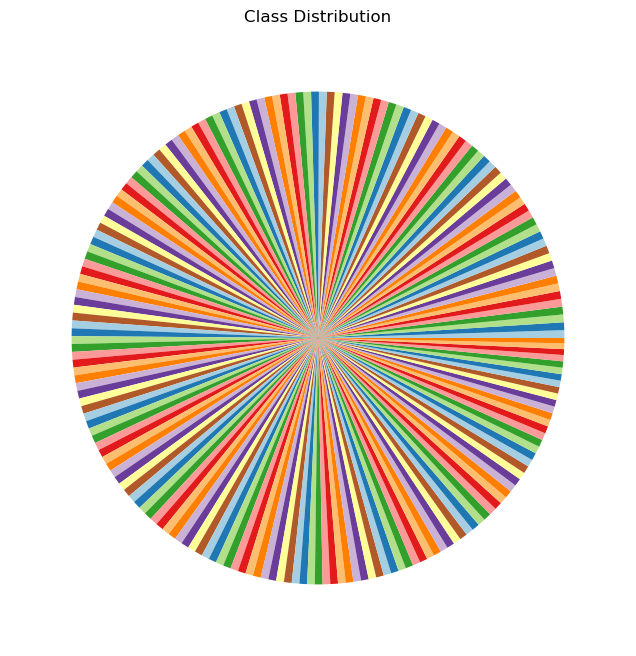

In [5]:
class_counts = labels['class_id'].value_counts()

print(f'Minimum class has {class_counts.min()} images')
print(f'Maximum class has {class_counts.max()} images')

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, colors=plt.cm.Paired.colors)
plt.title("Class Distribution")
plt.show()

## Bounding Boxes

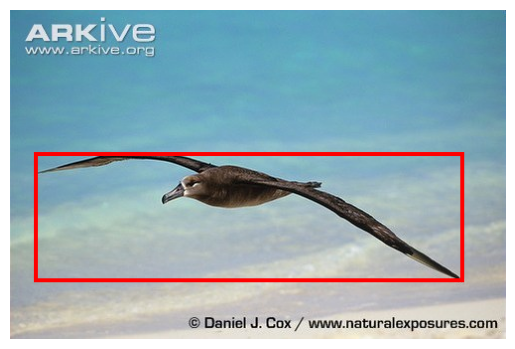

In [6]:
img_id = 50
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])
bb = bounding_boxes[bounding_boxes['image_id'] == img_id].iloc[0]
img = Image.open(img_path).convert('RGB')
x, y, width, height = bb['x'], bb['y'], bb['width'], bb['height']
x_min, y_min, x_max, y_max = x, y, x + width, y + height
draw = ImageDraw.Draw(img)
draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=4)
plt.imshow(img)
plt.axis('off')
plt.show()

## Parts

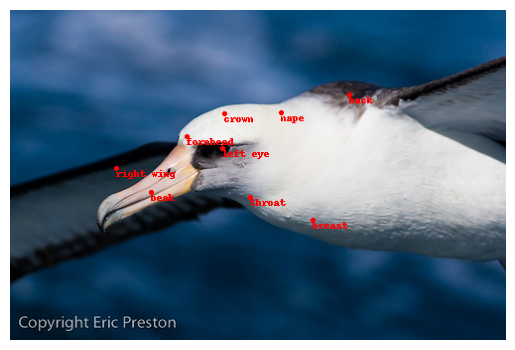

In [7]:
img_id = 80
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])
img = Image.open(img_path).convert('RGB')
draw = ImageDraw.Draw(img)

for part in part_locs[part_locs['img_id'] == img_id].itertuples():
    if (part.visible):
        draw.ellipse((part.x-2, part.y-2, part.x+2, part.y+2), fill='red')
        draw.text([part.x, part.y], parts[parts['part_id'] == part.part_id]['part_name'].iloc[0], fill='red')

plt.imshow(img)
plt.axis('off')
plt.show()

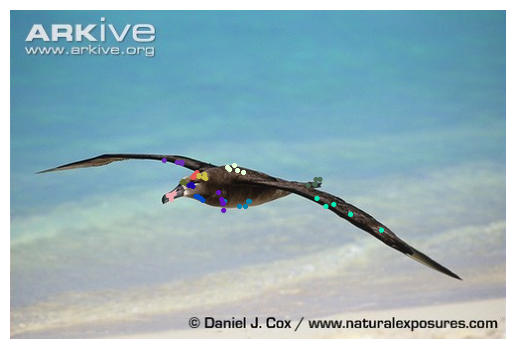

In [8]:
img_id = 50
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])
img = Image.open(img_path).convert('RGB')
draw = ImageDraw.Draw(img)
unique_parts = parts_click_locs[parts_click_locs['image_id'] == img_id]['part_id'].unique()
colors = {part: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for part in unique_parts}

for part in parts_click_locs[parts_click_locs['image_id'] == img_id].itertuples():
    if part.visible:
        draw.ellipse((part.x-2, part.y-2, part.x+2, part.y+2), fill=colors[part.part_id])

plt.imshow(img)
plt.axis('off')
plt.show()

## Attributes

Attribute has_bill_shape::hooked_seabird with certainty probably
Attribute has_wing_color::brown with certainty definitely
Attribute has_upperparts_color::brown with certainty definitely
Attribute has_underparts_color::brown with certainty definitely
Attribute has_breast_pattern::solid with certainty definitely
Attribute has_back_color::brown with certainty definitely
Attribute has_tail_shape::notched_tail with certainty definitely
Attribute has_upper_tail_color::brown with certainty definitely
Attribute has_head_pattern::eyering with certainty definitely
Attribute has_breast_color::brown with certainty definitely
Attribute has_throat_color::brown with certainty definitely
Attribute has_eye_color::black with certainty definitely
Attribute has_bill_length::about_the_same_as_head with certainty probably
Attribute has_forehead_color::brown with certainty probably
Attribute has_under_tail_color::brown with certainty definitely
Attribute has_nape_color::brown with certainty definitely
Attri

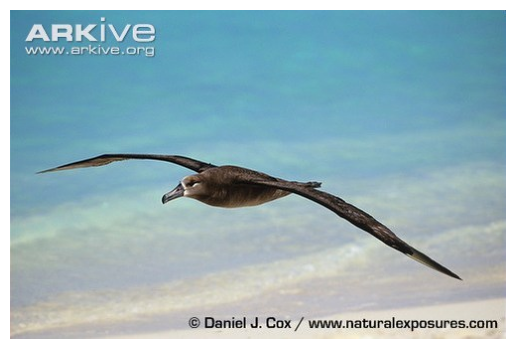

In [9]:
img_id = 50
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])
img = Image.open(img_path).convert('RGB')


for attribute in image_attribute_labels[image_attribute_labels['image_id'] == img_id].itertuples():
    if(attribute.is_present):
        print(f"Attribute {attributes[attributes['attribute_id'] == attribute.attribute_id]['attribute_name'].iloc[0]} with certainty {certainties[certainties['certainty_id'] == attribute.certainty_id]['certainty_name'].iloc[0]}")

plt.imshow(img)
plt.axis('off')
plt.show()